In [1]:
import os, gc
import numpy as np
#from numba import njit
import datatable as dtable
import pandas as pd


from sklearn.model_selection import GroupKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
import fastai
from fastai.tabular.all import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Preprocessing

In [3]:
%%time

print('Loading...')
train = dtable.fread('../input/jane-street-market-prediction/train.csv').to_pandas()
features = [c for c in train.columns if 'feature' in c]

print('Filling...')
train = train.query('weight > 0').reset_index(drop = True)
#train[features] = train[features].fillna(method = 'ffill').fillna(0)

print('Finish.')

Loading...
Filling...
Finish.
CPU times: user 30.4 s, sys: 10 s, total: 40.4 s
Wall time: 1min 6s


In [4]:
f_mean = train[features[1:]].mean()

In [5]:
train[features[1:]] = train[features[1:]].fillna(f_mean)

In [6]:
train[features].astype('float32')
train['action'] = (train['resp'] > 0).astype('int')

In [7]:
np.isnan(train.values).sum()

0

In [8]:
target_column = ['action']

In [9]:
len(features)

130

Deviding the data:

The easiest way is to use sklearn tool or even the fastai spilitter.
Actually I got better results deviding thee data with fastai splitters, where the date is not considered.

In [10]:
#gkf = GroupKFold(n_splits = 5)
#for fold, (tr, te) in enumerate(gkf.split(train['action'].values, train['action'].values, train['date'].values)):
    
    #X_tr, X_val = train.loc[tr, features], train.loc[te, features]
    #y_tr, y_val = train.loc[tr, target_column], train.loc[te, target_column]

In [11]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train))

In [12]:
len(splits[0])

1585030

In [13]:
X_tr, X_val = train.loc[splits[0], features], train.loc[splits[1], features]
y_tr, y_val = train.loc[splits[0], target_column], train.loc[splits[1], target_column]

Using the fastai DataLoader and Dataoaders is useful if you like to reduce the iteration time. The idea of creating the custom dataset class is simple and generally looks like the one created for pytorch application as created here https://towardsdatascience.com/deep-learning-using-pytorch-for-tabular-data-c68017d8b480.

The only difference is to return some value for the categories (cats), when they are not existing. np.zeros(len(df),).astype(np.long) will do this for us. Now we can return all values cats, conts and y.

In [14]:
class Fastai_Cust_Ds():
    def __init__(self, df, cats=None, y=None):
        df = df.copy()
                        
        if cats is not None: 
            self.dfcats = df[cats] #type: pandas.core.frame.DataFrame
            self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.long)
            self.dfconts = df.drop(cats, axis=1)
            self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32)
        else:

            self.dfconts = df.copy()
            self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32)
            self.cats = np.zeros(len(df),).astype(np.long)
        self.y = y.values
        
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):

        return [self.cats[idx], self.conts[idx], self.y[idx]]

In [15]:
train_ds = Fastai_Cust_Ds(df=X_tr, y=y_tr)
valid_ds = Fastai_Cust_Ds(df=X_val, y=y_val)

Now we create the data loader for the train and validation sets after importing the fastai DataLoader which is similar to the pytorch one.

In [16]:
from fastai.data.core import DataLoader

In [17]:
train_dl = DataLoader(train_ds, batch_size = 4096, drop_last=True, shuffle=False)
valid_dl = DataLoader(valid_ds, batch_size = 2048, drop_last=True, shuffle=False)

The fastai DataLoader is the next step, so it must be also imported.

In [18]:
from fastai.data.core import DataLoaders
dls = DataLoaders(train_dl,valid_dl,device='cuda')

In [19]:
dls.cats.shape, dls.conts.shape, dls.y.shape

((1585030,), (1585030, 130), (1585030, 1))

As we see, the values of cats were returned with zero values. This is important for the learner to accept the dls created.
.

There are also many useful options in both of DataLoader and DataLoaders of fastai that can be used here.  Drop_last and device are the most important.


The only problem of creating such a custom dataset in fastai, is that the inference can not be calculated using the learn.get_preds. Instead, we do learn.model.eval()  then we infer using preds = learn.model(0,test_df). I suppose that a small modification of the custom dataset may solve this problem.


As we will see in the custom model created here, its foreword function will need two values, one for the cats values, while the other one will take the x. The same must be done in the inference using  preds = learn.model(0,test_df).

In [20]:
train_ds.cats

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
class JanStr(nn.Module):

    def __init__(self):
        super(JanStr, self).__init__() 

        self.layers = nn.Sequential(

        nn.BatchNorm1d(130),
        LinBnDrop(130, 400, bn=True, p=0, act=Mish(), lin_first=False),
        LinBnDrop(400, 800, bn=True, p=0.2289, act=Mish(), lin_first=False),   
        LinBnDrop(800, 400, bn=True, p=0.2289, act=Mish(), lin_first=False),
        LinBnDrop(400, 2, bn=False, act=None, lin_first=False),

        ) 

    def forward(self,cat, x):
        x = self.layers(x)
        return F.softmax(x, dim=1)

The LinBnDrop is a very summarizing linear model of fastai dealing with three Batchnorm1D, nn.Linear and dropout. The forward function requires two values, cats for categories and x for the features.


In [22]:
model_nn = JanStr()
model_nn = model_nn.to(device)

In [23]:
loss_func = CrossEntropyLossFlat()

In [24]:
roc_auc = RocAucBinary()

In [25]:
learn = Learner(dls, model_nn, loss_func = loss_func, metrics=roc_auc)

In [26]:
callbacks = [
    EarlyStoppingCallback(monitor='valid_loss', min_delta=1e-5, patience=7),    
    ReduceLROnPlateau(monitor='valid_loss', min_delta=0.00001, patience=1, min_lr=1e-8),
    #SaveModelCallback(mode='min'),
    SaveModelCallback(monitor='valid_loss'),
]

SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=6.309573450380412e-07)

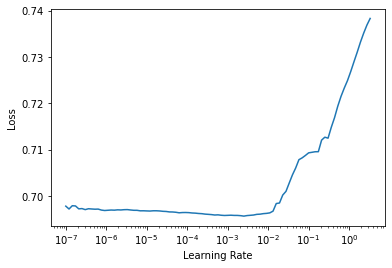

In [27]:
learn.lr_find()

In [28]:
lr=0.00005

In [29]:
learn.fit_one_cycle(20, lr, wd = 0.0001, cbs=callbacks)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.693253,0.691893,0.527782,00:44
1,0.692070,0.691273,0.533475,00:43
2,0.691483,0.690848,0.536346,00:43
3,0.690867,0.690525,0.538144,00:44
4,0.690587,0.690178,0.539915,00:43
5,0.690418,0.689866,0.541771,00:43
6,0.690049,0.689601,0.542981,00:44
7,0.689736,0.689386,0.544236,00:43
8,0.689446,0.689178,0.545255,00:43
9,0.689405,0.688938,0.546451,00:44


Better model found at epoch 0 with valid_loss value: 0.6918925046920776.
Better model found at epoch 1 with valid_loss value: 0.6912734508514404.
Better model found at epoch 2 with valid_loss value: 0.690848171710968.
Better model found at epoch 3 with valid_loss value: 0.6905250549316406.
Better model found at epoch 4 with valid_loss value: 0.6901783347129822.
Better model found at epoch 5 with valid_loss value: 0.6898655891418457.
Better model found at epoch 6 with valid_loss value: 0.6896011829376221.
Better model found at epoch 7 with valid_loss value: 0.6893863677978516.
Better model found at epoch 8 with valid_loss value: 0.6891781687736511.
Better model found at epoch 9 with valid_loss value: 0.6889375448226929.
Better model found at epoch 10 with valid_loss value: 0.6887773871421814.
Better model found at epoch 11 with valid_loss value: 0.6886038780212402.
Better model found at epoch 12 with valid_loss value: 0.6884658336639404.
Better model found at epoch 13 with valid_loss va

In [30]:
def fill_nan(test_df):
    test_df=test_df[features]
    xar=test_df[features].values
    na_arr=np.ones((1,len(features)), dtype=float)
    na_arr=na_arr*(999)
    xar = xar - na_arr
    xar = np.nan_to_num(xar, nan=-999)
    xar = xar + na_arr
    test_df = torch.FloatTensor(xar)
    return test_df

In [31]:
learn.model.eval()
import janestreet
env = janestreet.make_env()
env_iter = env.iter_test()

In [32]:
for (test_df, pred_df) in tqdm(env_iter):
    X_test = fill_nan(test_df).cuda()
    preds = learn.model(0,X_test).argmax(dim=1).detach().cpu().numpy()
    eps=0.5

    #action = ((test_df['weight'].values * probas[:, 1]) > 0).astype('int')
    if test_df['weight'].item() == 0:
        action=0
    else:
        action=preds
    pred_df.action = action
    env.predict(pred_df)

15219it [03:33, 71.31it/s]
